# Classification of Skin Cancers


In [40]:
import shutil
import pathlib
import random
from typing import Callable

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms.v2 

import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn.functional as F

import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

---
## Data Exploration and Class Distribution Analysis
#### This section involves an initial exploration of the HAM10000 dataset to ensure the correctness of the labels and understand the class distribution.

In [41]:
records = pd.read_csv("/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv")
records.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# verify that each image only have 1 positive class
num_positive = records[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].sum(axis=1).astype(int)
print(f"Number of classes per image: {', '.join(list(num_positive.astype(str).unique()))}")

Number of classes per image: 1


In [43]:
# compare the number of instances in each class
num_classes = records[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].sum(axis=0).astype(int)
print(num_classes)

MEL      1113
NV       6705
BCC       514
AKIEC     327
BKL      1099
DF        115
VASC      142
dtype: int64


In [44]:
# Define class_frequencies from the 'num_classes' Series
class_frequencies = num_classes.values.tolist()

print(class_frequencies)

[1113, 6705, 514, 327, 1099, 115, 142]


---
# Creating the Train, Validation, and Test Splits


In [45]:
# create column for stratify
records['class'] = records.apply((lambda x: x[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].argmax()), axis=1)

# divide images
remaining, test = train_test_split(records, test_size=0.2, random_state=42, stratify=records["class"])
train, validation = train_test_split(remaining, test_size=0.25, random_state=42, stratify=remaining["class"])

print(f"Number of train images: {len(train)}")
print(f"Number of validation images: {len(validation)}")
print(f"Number of test images: {len(test)}")

Number of train images: 6009
Number of validation images: 2003
Number of test images: 2003


In [46]:
# create train set
print("Creating Train Data")
train.to_csv("/kaggle/working/train.csv", index=False)

# create validation set
print("Creating Validation Data")
validation.to_csv("/kaggle/working/validation.csv", index=False)

# create test set
print("Creating Test Data")
test.to_csv("/kaggle/working/test.csv", index=False)

Creating Train Data
Creating Validation Data
Creating Test Data




---
# Dataset Preparation for Segmentation and Classification
#### This section describes the steps to prepare the HAM10000 dataset for training, validation, and testing tasks. The dataset includes paired images, segmentation masks, and multi-class labels

### Key Steps

#### Dataset Creation (`create_dataset`)
- Constructs file paths for images and masks.
- Converts multi-class labels into PyTorch tensors.
- Prepares subsets: `train`, `validation`, and `test`.

#### Custom Dataset Class (`SegmentationDataset`)
- **Input Handling**: 
  - Loads images and masks.
  - Normalizes them to the range `[0, 1]`.
  - Resizes them to `(224, 224)`.
- **Output**: Provides preprocessed image-mask-label tuples for model input.

#### Dataset Initialization
- Train, validation, and test datasets are instantiated using the `SegmentationDataset` class, ensuring structured and efficient data access.






In [47]:
def create_dataset(subset: str):
    df = pd.read_csv(f"/kaggle/working/{subset}.csv")
    X = df['image'].apply(lambda x: '/kaggle/input/ham1000-segmentation-and-classification/images/' + x + '.jpg').astype(str).to_list()
    M = df['image'].apply(lambda x: '/kaggle/input/ham1000-segmentation-and-classification/masks/' + x + '_segmentation.png').astype(str).to_list()
    y = torch.from_numpy(df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].to_numpy()).type(torch.float32)
    return X,M,y

class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, X: torch.tensor,M:torch.tensor, y: torch.tensor):
        super().__init__()
        
        self.X = X
        self.M=M
        self.y = y
        
    def __getitem__(self, i: int):
        image = torchvision.io.read_image(self.X[i])
        image = image.type(torch.float32) / 255
        image = torchvision.transforms.v2.functional.resize(image, (224, 224), antialias=True)

        mask = torchvision.io.read_image(self.M[i])
        mask = mask.type(torch.float32) / 255
        mask = torchvision.transforms.v2.functional.resize(mask, (224, 224), antialias=True)
        
        return image,mask, self.y[i]
    
    def __len__(self):
        return len(self.X)


train_images, train_masks, train_labels = create_dataset("train")
val_images, val_masks, val_labels = create_dataset("validation")
test_images, test_masks, test_labels = create_dataset("test")

train_ds = SegmentationDataset(train_images, train_masks, train_labels)
validation_ds = SegmentationDataset(val_images, val_masks, val_labels)
test_ds = SegmentationDataset(test_images, test_masks, test_labels)




---
## plot images, masks, and labels from the training dataset

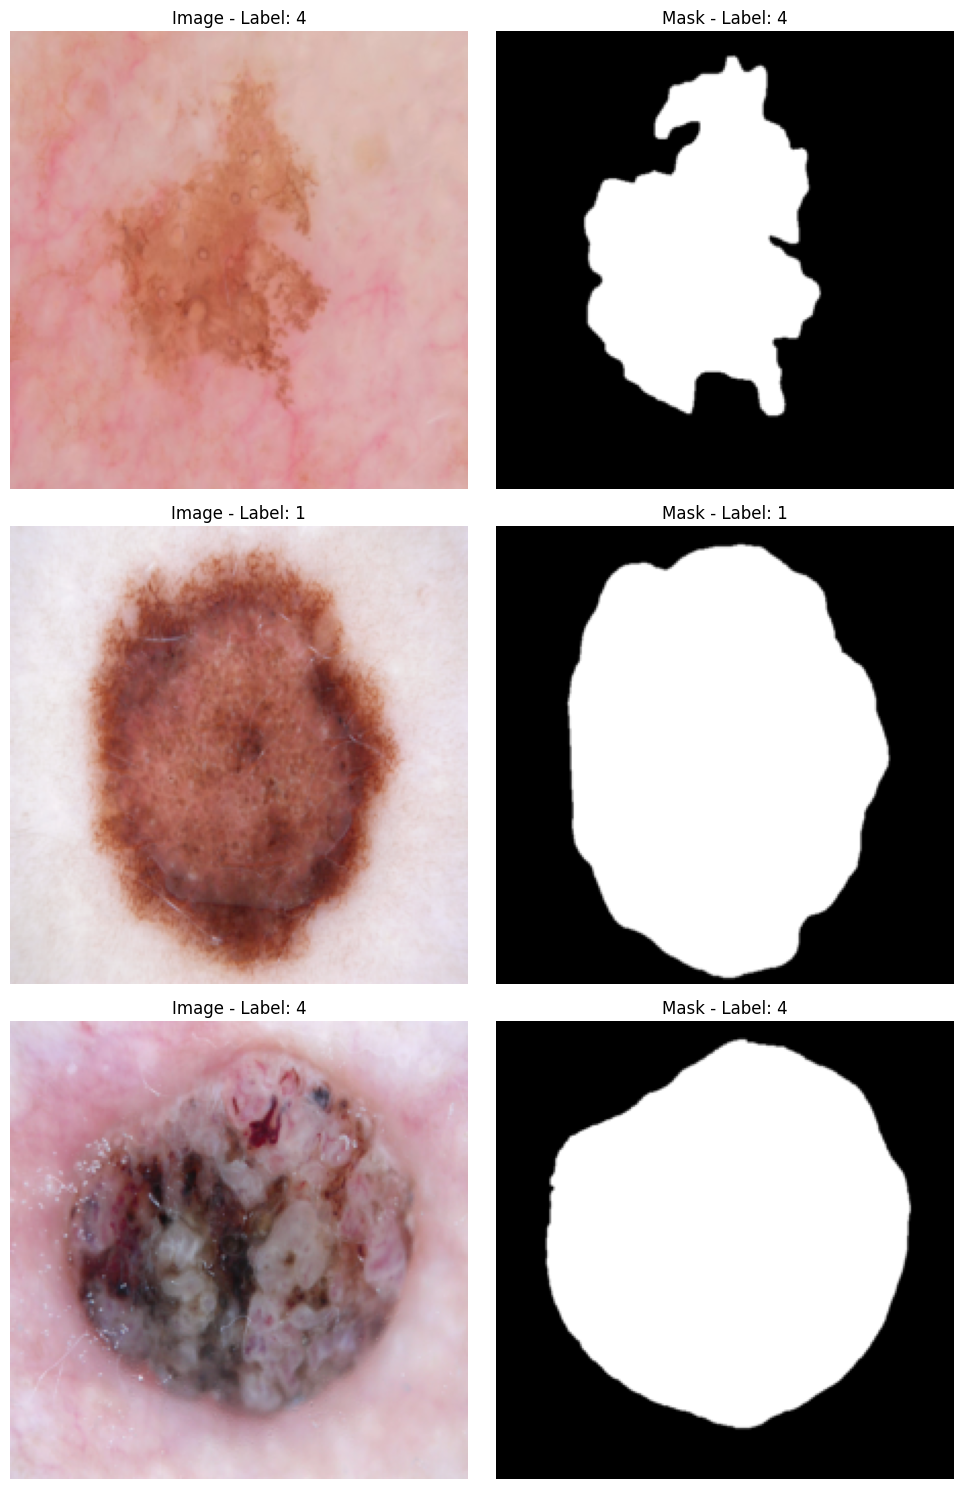

In [9]:
def plot_images_with_masks(dataset, num_samples=3):

    indices = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
    
    for i, idx in enumerate(indices):
        # Get image, mask, and label for the current sample
        image, mask, label = dataset[idx]
        
        # Convert image and mask tensors to numpy for display
        image = image.permute(1, 2, 0).cpu().numpy()  # Convert from CxHxW to HxWxC
        mask = mask.squeeze().cpu().numpy()  # Squeeze mask to remove the channel dimension
        
        # Plot image and mask side by side
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Image - Label: {label.argmax().item()}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f"Mask - Label: {label.argmax().item()}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot images, masks, and labels from the training dataset
plot_images_with_masks(train_ds, num_samples=3)


---
### Multi-Task Model for Classification and Segmentation

This model combines classification and segmentation tasks using a shared **ResNet-18 backbone** with separate task-specific heads.

#### Architecture
1. **Backbone**: Pre-trained ResNet-18 (features extracted from convolutional layers).
2. **Classification Head**: Fully connected layers with BatchNorm, ReLU, and Dropout, ending in a `num_classes` output layer.
3. **Segmentation Head**: Convolutional and transposed convolutional layers with BatchNorm, ReLU, and Dropout. The output is upsampled to `(224x224)`.

#### Forward Pass
- **Input**: Tensor of shape `(N, C, H, W)`.
- **Outputs**:
  - **Classification**: Logits for `num_classes`.
  - **Segmentation**: Predicted masks of size `(N, 1, 224, 224)`.

#### Highlights
- **Multi-Task Learning**: Efficient handling of classification and segmentation.
- **Regularization**: Dropout layers reduce overfitting.
- **Flexibility**: Easily extendable for different resolutions or tasks.

This setup ensures a robust pipeline for joint learning of image classification and segmentation tasks.


In [48]:
class MultiTaskModel(nn.Module):
    def __init__(self, num_classes=7):
        super(MultiTaskModel, self).__init__()
        # Load pre-trained ResNet-18
        self.backbone = models.resnet18(pretrained=True)
        
        # Remove the fully connected layer (head) of ResNet
        self.features = nn.Sequential(*list(self.backbone.children())[:-2])


        # Classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(self.backbone.fc.in_features, 512),  # Increase the size of the first hidden layer
            nn.BatchNorm1d(512),  # Batch Normalization after Linear layer
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256), 
            nn.BatchNorm1d(256),  
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Linear(256, 128), 
            nn.BatchNorm1d(128), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Linear(128, 64),  
            nn.BatchNorm1d(64), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Linear(64, num_classes)  # Output layer
        )
        
        # Segmentation head
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(self.backbone.fc.in_features, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            )

    def forward(self, x):
        features = self.features(x)
        # Classification output
        classification_output = self.classifier(features)
        # Segmentation output
        segmentation_output = self.segmentation_head(features)
        # Resize segmentation output to match the target mask size (224x224)
        segmentation_output = F.interpolate(segmentation_output, size=(224, 224), mode='bilinear', align_corners=False)
        return classification_output, segmentation_output


In [49]:
model = MultiTaskModel(num_classes=7)
print(f"Total parameters in the model: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


Total parameters in the model: 13472112


___
## Model Training Configuration with Class Weights and Loss Functions

This strategy, by emphasizing the minority classes through higher weights, helps the model better handle class imbalances, leading to more balanced performance across all classes during training.



In [50]:
#  Calculate class weights
class_weights = torch.tensor([1 / class_freq for class_freq in class_frequencies])

# Normalize the weights (optional but can help with stability)
class_weights = class_weights / class_weights.sum()


# Loss functions
classification_criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
#classification_criterion = nn.CrossEntropyLoss()
segmentation_criterion = nn.BCEWithLogitsLoss()

# Optimizer with weight decay (L2 regularization)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Move to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)


## Creating dataloaders
The DataLoader is responsible for loading the data in batches, which is crucial for efficient training

In [51]:
# Batch size and DataLoader settings
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(validation_ds, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)


# training + validation loop

In [53]:

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0
    for images, masks, labels in train_loader:
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)
        
        # Check if labels are one-hot encoded
        if labels.dim() > 1:  # If labels have more than one dimension (i.e., one-hot encoded)
            labels = torch.argmax(labels, dim=1)  # Convert to class indices

        # Forward pass and compute loss for classification and segmentation
        preds_cls, preds_seg = model(images)
        loss_cls = classification_criterion(preds_cls, labels)
        loss_seg = segmentation_criterion(preds_seg, masks)
        loss = loss_cls + loss_seg
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(preds_cls, 1)  # Get the class with the highest probability
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Average train loss and accuracy for the epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, masks, labels in val_loader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            
            # Check if labels are one-hot encoded
            if labels.dim() > 1:  # If labels have more than one dimension (i.e., one-hot encoded)
                labels = torch.argmax(labels, dim=1)  # Convert to class indices

            # Forward pass for validation
            preds_cls, preds_seg = model(images)
            loss_cls = classification_criterion(preds_cls, labels)
            loss_seg = segmentation_criterion(preds_seg, masks)
            loss = loss_cls + loss_seg
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(preds_cls, 1)  # Get the class with the highest probability
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Average validation loss and accuracy for the epoch
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print training and validation loss and accuracy for the current epoch
    print(
        f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}"
    )


Epoch [1/10], Train Loss: 2.4937, Train Acc: 0.1300, Val Loss: 2.1243, Val Acc: 0.4353
Epoch [2/10], Train Loss: 2.2399, Train Acc: 0.2438, Val Loss: 1.9495, Val Acc: 0.3984
Epoch [3/10], Train Loss: 2.0437, Train Acc: 0.3666, Val Loss: 1.7392, Val Acc: 0.5047
Epoch [4/10], Train Loss: 1.9252, Train Acc: 0.4200, Val Loss: 1.6610, Val Acc: 0.4833
Epoch [5/10], Train Loss: 1.7891, Train Acc: 0.4853, Val Loss: 1.5857, Val Acc: 0.5562
Epoch [6/10], Train Loss: 1.7055, Train Acc: 0.5176, Val Loss: 1.5346, Val Acc: 0.5936
Epoch [7/10], Train Loss: 1.6098, Train Acc: 0.5776, Val Loss: 1.4780, Val Acc: 0.6001
Epoch [8/10], Train Loss: 1.5209, Train Acc: 0.6156, Val Loss: 1.4083, Val Acc: 0.6440
Epoch [9/10], Train Loss: 1.3977, Train Acc: 0.6345, Val Loss: 1.3182, Val Acc: 0.6470
Epoch [10/10], Train Loss: 1.3006, Train Acc: 0.6470, Val Loss: 1.3043, Val Acc: 0.6940


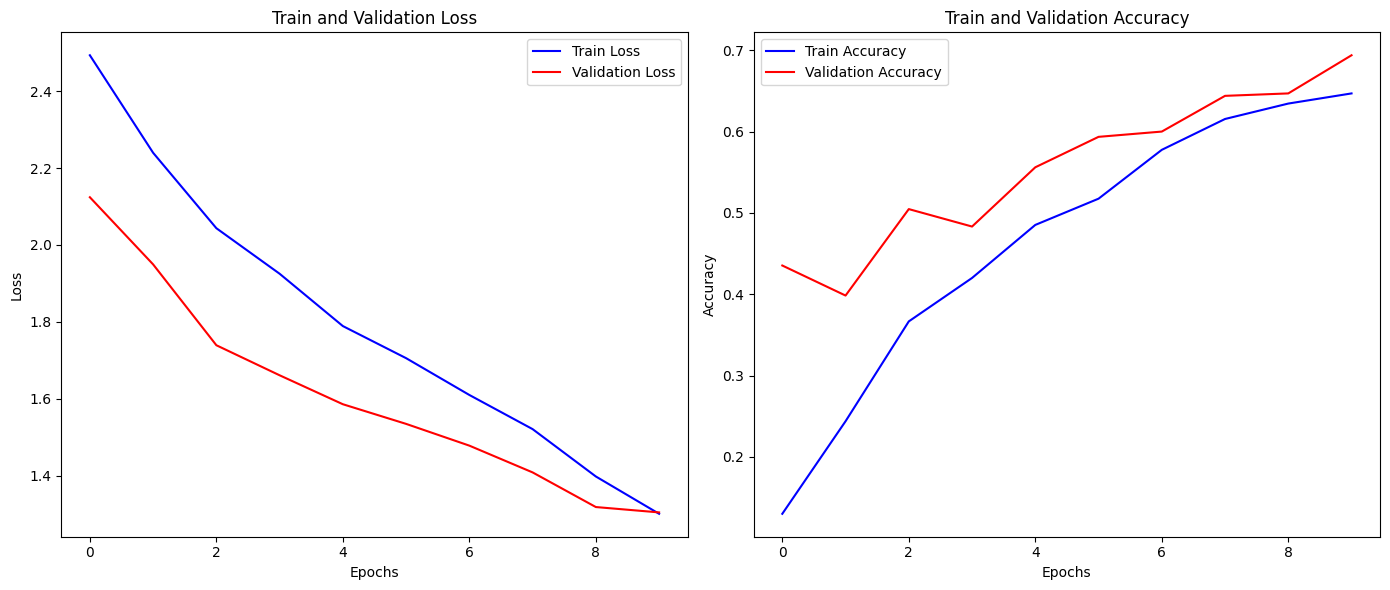

In [60]:
# Plotting training and validation loss, and accuracy side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the train and validation loss
axs[0].plot(range(num_epochs), train_losses, label="Train Loss", color='blue')
axs[0].plot(range(num_epochs), val_losses, label="Validation Loss", color='red')
axs[0].set_title('Train and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting the train and validation accuracy
axs[1].plot(range(num_epochs), train_accuracies, label="Train Accuracy", color='blue')
axs[1].plot(range(num_epochs), val_accuracies, label="Validation Accuracy", color='red')
axs[1].set_title('Train and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

### Display Total Number of Parameters in the Model:

In [54]:
# Display the total number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f'Total number of parameters in the model: {total_params}')


Total number of parameters in the model: 13472112


---
# Evaluate the Model on the Test Set:

In [55]:

# Set the model to evaluation mode
model.eval()

# Variables to store true labels and predicted labels
all_labels = []
all_preds = []

with torch.no_grad():
    for images, masks, labels in test_loader:  # Assuming `test_loader` is your DataLoader for the test set
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)
        
        # Forward pass
        preds_cls, _ = model(images)  # Only need the classification output
        
        # Get the predicted class labels (taking the argmax of the output)
        _, predicted = torch.max(preds_cls, 1)
        
        # Store the true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for evaluation
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# If labels are one-hot encoded (i.e., shape is (n_samples, num_classes)), 
# use np.argmax to get the class indices
if len(all_labels.shape) > 1 and all_labels.shape[1] > 1:
    all_labels = np.argmax(all_labels, axis=1)

# Compute overall accuracy
accuracy = np.mean(all_preds == all_labels)
print(f'Overall Accuracy: {accuracy:.4f}')



Overall Accuracy: 0.6770


# confusion matrix

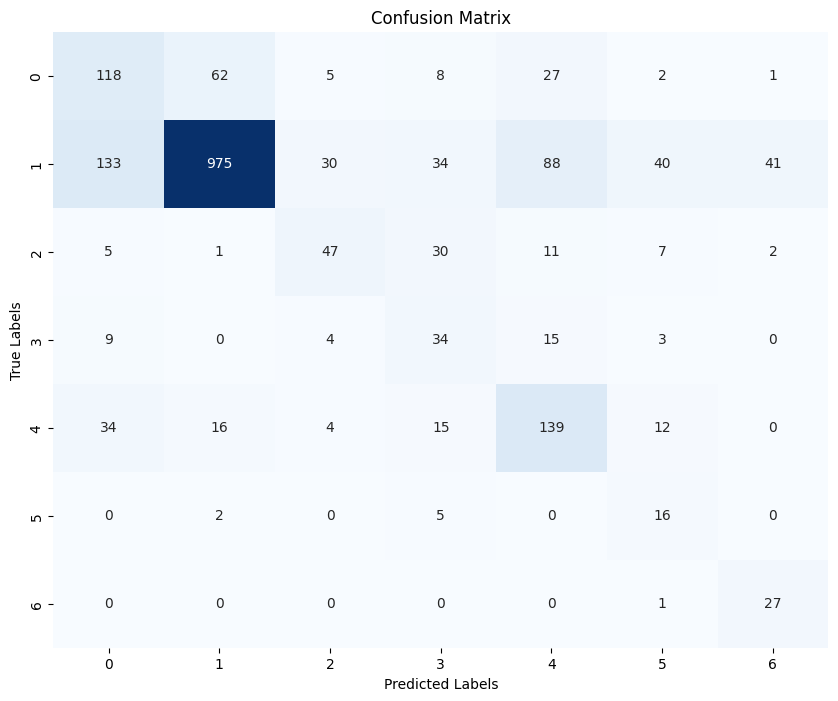

In [56]:
# Assuming `all_preds` and `all_labels` are your predicted and true labels
# all_preds = np.array(all_preds)
# all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(7)], yticklabels=[str(i) for i in range(7)], cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Precision, Recall, and F1-Score per Class:

In [57]:
# Print the precision, recall, and F1 score per class
print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.39      0.53      0.45       223
           1       0.92      0.73      0.81      1341
           2       0.52      0.46      0.49       103
           3       0.27      0.52      0.36        65
           4       0.50      0.63      0.56       220
           5       0.20      0.70      0.31        23
           6       0.38      0.96      0.55        28

    accuracy                           0.68      2003
   macro avg       0.45      0.65      0.50      2003
weighted avg       0.76      0.68      0.70      2003



---
##  1. Intersection over Union (IoU)
#### IoU is a metric that evaluates the overlap between the predicted segmentation and the ground truth segmentation. It is calculated as:
### IoU = TP/(TP + FP + FN)


##
##  2. Dice Coefficient
#### The Dice coefficient (or Dice Similarity Coefficient, DSC) is another measure of overlap between the predicted segmentation and the ground truth. It is computed as:
### Dice = (2*TP)/(2*TP + FP + FN)

#
### Where:

#### TP = True Positives (correctly predicted pixels)

#### FP = False Positives (incorrectly predicted as the target)

#### FN = False Negatives (incorrectly predicted as background)


In [58]:
def compute_metrics(preds, targets, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum()
    union = (preds + targets).sum() - intersection
    dice = (2 * intersection) / (preds.sum() + targets.sum())
    iou = intersection / union
    return dice.item(), iou.item()

# Evaluate on test set
model.eval()
with torch.no_grad():
    dice_scores, iou_scores = [], []
    for images, masks, _ in test_loader:
        images, masks = images.to(device), masks.to(device)
        _, preds_seg = model(images)
        dice, iou = compute_metrics(preds_seg, masks)
        dice_scores.append(dice)
        iou_scores.append(iou)
    print(f"Mean Dice Coefficient: {np.mean(dice_scores):.4f}")
    print(f"Mean IoU: {np.mean(iou_scores):.4f}")


Mean Dice Coefficient: 0.8383
Mean IoU: 0.7270


In [59]:


# Function to calculate IoU and Dice
def calculate_metrics(preds, targets, threshold=0.5):
    # Convert predictions to binary (thresholded at 0.5)
    preds = (preds > threshold).float()
    
    # Flatten the tensors
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    # Compute True Positives, False Positives, False Negatives
    TP = torch.sum(preds * targets)
    FP = torch.sum(preds * (1 - targets))
    FN = torch.sum((1 - preds) * targets)
    
    # Compute IoU
    IoU = TP / (TP + FP + FN)
    
    # Compute Dice Coefficient
    Dice = 2 * TP / (2 * TP + FP + FN)
    
    return IoU.item(), Dice.item()

# Assuming preds_seg is the predicted segmentation output and masks are the ground truth
model.eval()
with torch.no_grad():
    all_iou = []
    all_dice = []
    for images, masks, labels in test_loader:
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)
        
        # Forward pass
        preds_cls, preds_seg = model(images)
        
        # Calculate IoU and Dice
        iou, dice = calculate_metrics(preds_seg, masks)
        
        all_iou.append(iou)
        all_dice.append(dice)
    
    # Average IoU and Dice across the test set
    mean_iou = np.mean(all_iou)
    mean_dice = np.mean(all_dice)
    
    print(f"Average IoU: {mean_iou:.4f}")
    print(f"Average Dice Coefficient: {mean_dice:.4f}")


Average IoU: 0.7238
Average Dice Coefficient: 0.8359
